# Task 3: Customer Segmentation / Clustering

In [18]:
import os

In [19]:
# Set the environment variable to avoid the MKL memory leak issue
os.environ["OMP_NUM_THREADS"] = "1"

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Load the data

In [21]:
customers = pd.read_csv('D:\Datasets\Customers.csv')

In [22]:
transactions = pd.read_csv('D:\Datasets\Transactions.csv')

# Aggregate transaction data for each customer

In [23]:
transaction_summary = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',    
    'TransactionID': 'count'
}).reset_index()

# Merge with customer profile data

In [24]:
customer_data = pd.merge(customers, transaction_summary, on='CustomerID', how='inner')

# Convert `SignupDate` to days since signup for numerical analysis

In [25]:
customer_data['SignupDate'] = pd.to_datetime(customer_data['SignupDate'])

In [26]:
customer_data['DaysSinceSignup'] = (pd.Timestamp.now() - customer_data['SignupDate']).dt.days

# Drop unnecessary columns

In [27]:
customer_data.drop(columns=['SignupDate', 'CustomerName'], inplace=True)

# Encode categorical variables

In [28]:
customer_data = pd.get_dummies(customer_data, columns=['Region'], drop_first=True)

# Separate features and scale the data

In [29]:
features = customer_data.drop(columns=['CustomerID']) 
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply KMeans clustering with a range of clusters to find the optimal k

In [34]:
cluster_range = range(2, 11)
db_scores = []

In [35]:
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, labels)
    db_scores.append(db_index)

C:\Users\sudhi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\sudhi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\sudhi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\sudhi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

# Find the optimal number of clusters 

In [13]:
optimal_k = cluster_range[np.argmin(db_scores)]
print(f"Optimal number of clusters: {optimal_k}")

Optimal number of clusters: 10


# Fit the model with the optimal K

In [36]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(scaled_features)

C:\Users\sudhi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\sudhi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


# Calculate DB Index for final clustering

In [37]:
final_db_index = davies_bouldin_score(scaled_features, customer_data['Cluster'])
print(f"Davies-Bouldin Index for final clustering: {final_db_index}")

Davies-Bouldin Index for final clustering: 1.0574478397387534


# Calculate Silhouette Score

In [38]:
silhouette_avg = silhouette_score(scaled_features, customer_data['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.31864620953417155


# Cluster Sizes

In [39]:
cluster_sizes = customer_data['Cluster'].value_counts()
print(f"Cluster Sizes: \n{cluster_sizes}")

Cluster Sizes: 
1    28
7    26
4    25
3    22
5    21
6    21
0    20
8    17
9    10
2     9
Name: Cluster, dtype: int64


# Visualize the clusters using PCA for dimensionality reduction

In [40]:
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

# Plot the clusters

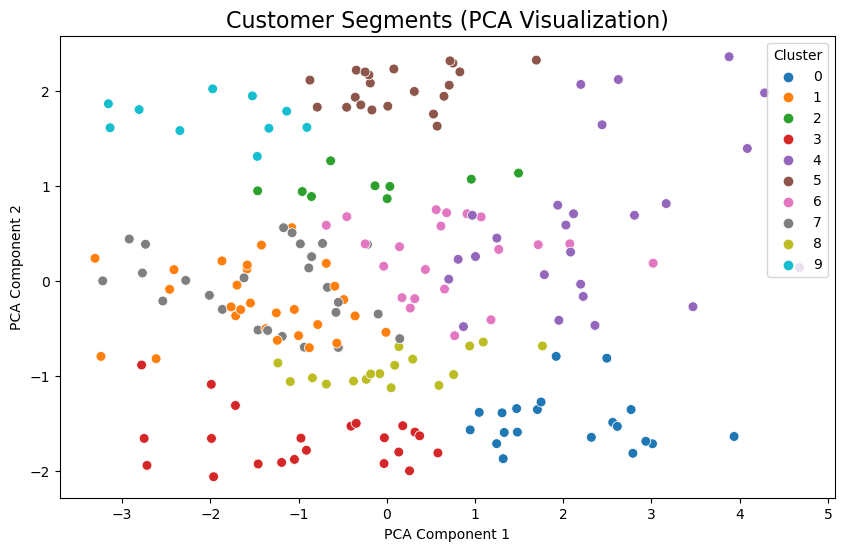

In [41]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=customer_data['Cluster'], palette='tab10', s=50)
plt.title("Customer Segments (PCA Visualization)", fontsize=16)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster", loc="upper right")
plt.show()